In [49]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

### Carga y transformación

In [50]:
ruta = 'data/clean_data/nasdaq.csv'
serie = pd.read_csv(ruta, names=['Valores'])

# 1.1 Solo logaritmo (NO diferenciación)
s_log = np.log(serie['Valores'].values)

# 1.2 DIVISIÓN ANTES DE NORMALIZAR
total_len = len(s_log)
train_size = int(total_len * 0.8)
val_size = int(total_len * 0.1)
test_size = total_len - train_size - val_size

s_log_train = s_log[:train_size]
s_log_val = s_log[train_size:train_size + val_size]
s_log_test = s_log[train_size + val_size:]

# 1.3 Normalización (solo con datos de entrenamiento)
scaler = StandardScaler()
s_log_train_norm = scaler.fit_transform(s_log_train.reshape(-1, 1)).flatten()
s_log_val_norm = scaler.transform(s_log_val.reshape(-1, 1)).flatten()
s_log_test_norm = scaler.transform(s_log_test.reshape(-1, 1)).flatten()

# Guardar parámetros para desnormalizar
mu_log = scaler.mean_[0]
sigma_log = scaler.scale_[0]

print(f"Datos totales: {total_len}")
print(f"Train: {len(s_log_train_norm)}, Val: {len(s_log_val_norm)}, Test: {len(s_log_test_norm)}")
print(f"Media (mu_log): {mu_log:.6f}, Desviación (sigma_log): {sigma_log:.6f}")

Datos totales: 1500
Train: 1200, Val: 150, Test: 150
Media (mu_log): 6.343113, Desviación (sigma_log): 0.240596


### Crear ventanas

In [51]:
def crear_ventanas(serie, ventana):
    X, y = [], []
    for i in range(len(serie) - ventana):
        X.append(serie[i:i + ventana])
        y.append(serie[i + ventana])
    return np.array(X), np.array(y)

ventana = 100  # Mantenemos ventana grande para capturar tendencia

X_train, y_train = crear_ventanas(s_log_train_norm, ventana)
X_val, y_val = crear_ventanas(s_log_val_norm, ventana)
X_test, y_test = crear_ventanas(s_log_test_norm, ventana)

print(f"\nShapes después de crear ventanas:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


Shapes después de crear ventanas:
X_train: (1100, 100), y_train: (1100,)
X_val: (50, 100), y_val: (50,)
X_test: (50, 100), y_test: (50,)


### Convertir en tensores

In [52]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Datasets y DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Definir el modelo CNN 1D

In [61]:
class Conv1D(nn.Module):
    def __init__(self, window_size=100):
        super().__init__()
        # Arquitectura simple sin BatchNorm ni Dropout (para empezar)
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 100 → 50
            
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # 50 → 1
        )
        self.fc = nn.Linear(64, 1)
    
    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze(-1)
        return self.fc(x)

# Prueba con este modelo simple primero
test_model = Conv1D(window_size=ventana)
print(f"Modelo simple. Parámetros: {sum(p.numel() for p in test_model.parameters()):,}")

Modelo simple. Parámetros: 6,465


### Funciónes para entrenamiento

In [54]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.unsqueeze(1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def validate_epoch(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss = criterion(output, target.unsqueeze(1))
            val_loss += loss.item()
    return val_loss / len(val_loader)


### Entrenamiento

In [63]:
model = Conv1D(window_size=ventana)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento rápido para verificar funcionamiento
train_losses = []
val_losses = []

for epoch in range(10):  # Solo 10 épocas para prueba
    # Entrenamiento
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))
    
    # Validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f'Época {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}')


Época 1: Train Loss = 0.4065, Val Loss = 0.2100
Época 2: Train Loss = 0.1808, Val Loss = 0.1578
Época 3: Train Loss = 0.1378, Val Loss = 0.0274
Época 4: Train Loss = 0.1715, Val Loss = 0.0851
Época 5: Train Loss = 0.1261, Val Loss = 0.0164
Época 6: Train Loss = 0.1454, Val Loss = 0.0548
Época 7: Train Loss = 0.1171, Val Loss = 0.0201
Época 8: Train Loss = 0.1263, Val Loss = 0.0378
Época 9: Train Loss = 0.1163, Val Loss = 0.0239
Época 10: Train Loss = 0.1203, Val Loss = 0.0319



=== ESTADÍSTICAS EN ESCALA NORMALIZADA ===
Predicciones - Min: 2.154460, Max: 2.418467
Reales       - Min: 2.277565, Max: 2.627278

=== ESTADÍSTICAS EN ESCALA ORIGINAL (USD) ===
Predicciones - Min: $954.77, Max: $1017.38
Reales       - Min: $983.47, Max: $1069.80

RESULTADOS FINALES - ESCALA ORIGINAL
MSE:  2461.58
RMSE: $49.61
MAE:  $46.07
R²:   -5.2026

Error porcentual promedio: -4.43%
Error absoluto % promedio: 4.43%
Correlación: 0.5550
Precisión dirección: 49.0%


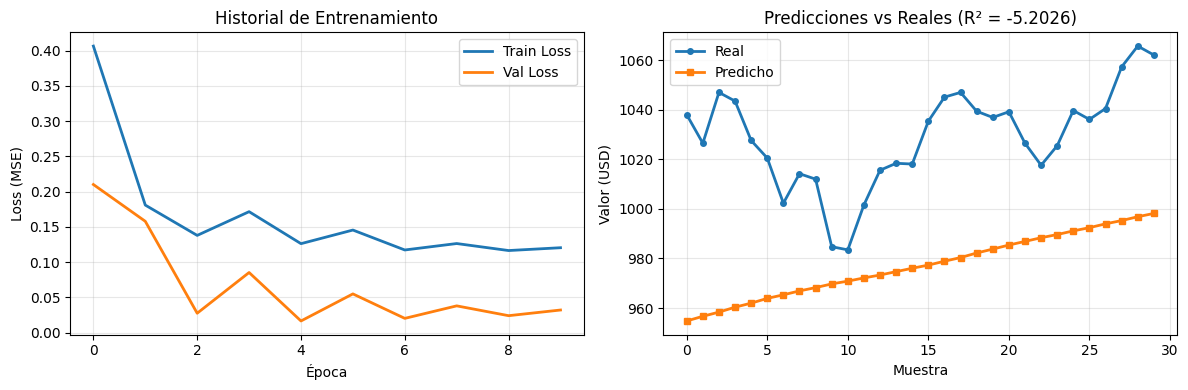

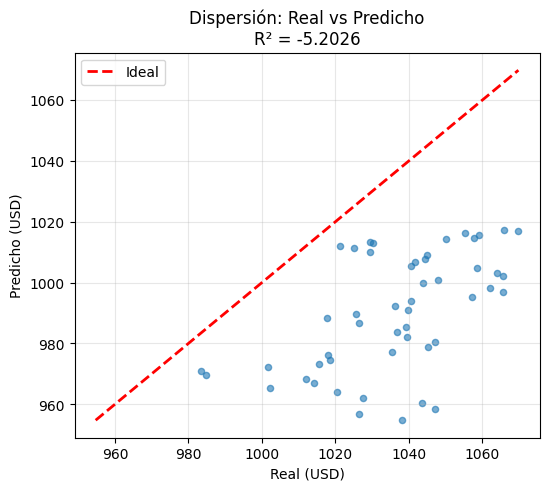


ANÁLISIS DETALLADO DE ERRORES

Primeros 5 ejemplos:
Índice   Real         Predicho     Error        Error %   
------------------------------------------------------------
0        $1038.00     $954.77      $-83.23      -8.02     %
1        $1026.50     $956.66      $-69.84      -6.80     %
2        $1047.00     $958.34      $-88.66      -8.47     %
3        $1043.50     $960.33      $-83.17      -7.97     %
4        $1027.60     $961.96      $-65.64      -6.39     %


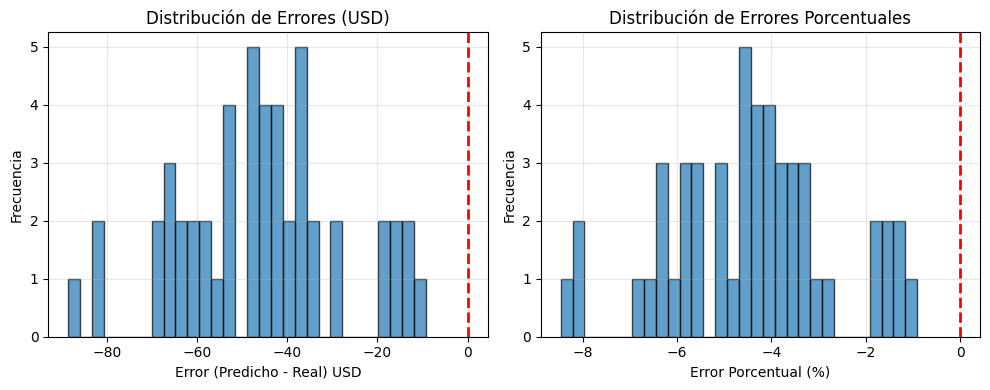

In [64]:
# ==================== EVALUACIÓN CORRECTA ====================

def evaluar_y_recuperar(model, test_loader, mu_log, sigma_log):
    """Evalúa el modelo y recupera correctamente a escala original"""
    model.eval()
    predictions_norm = []
    targets_norm = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            predictions_norm.extend(y_pred.flatten().numpy())
            targets_norm.extend(y_batch.numpy())
    
    # Convertir a arrays numpy
    pred_norm = np.array(predictions_norm)
    target_norm = np.array(targets_norm)
    
    print("\n=== ESTADÍSTICAS EN ESCALA NORMALIZADA ===")
    print(f"Predicciones - Min: {pred_norm.min():.6f}, Max: {pred_norm.max():.6f}")
    print(f"Reales       - Min: {target_norm.min():.6f}, Max: {target_norm.max():.6f}")
    
    # RECUPERACIÓN CORRECTA:
    # 1. Desnormalizar (volver a escala logarítmica)
    pred_log = pred_norm * sigma_log + mu_log
    target_log = target_norm * sigma_log + mu_log
    
    # 2. Aplicar exponencial (volver a escala original USD)
    pred_original = np.exp(pred_log)
    target_original = np.exp(target_log)
    
    print("\n=== ESTADÍSTICAS EN ESCALA ORIGINAL (USD) ===")
    print(f"Predicciones - Min: ${pred_original.min():.2f}, Max: ${pred_original.max():.2f}")
    print(f"Reales       - Min: ${target_original.min():.2f}, Max: ${target_original.max():.2f}")
    
    return pred_original, target_original, pred_norm, target_norm

# Ejecutar evaluación
pred_original, target_original, pred_norm, target_norm = evaluar_y_recuperar(
    model, test_loader, mu_log, sigma_log
)

# ==================== CÁLCULO CORRECTO DE MÉTRICAS ====================

def calcular_metricas_correctas(pred_original, target_original):
    """Calcula métricas de forma correcta en escala original"""
    
    # 1. Métricas básicas
    mse = np.mean((pred_original - target_original) ** 2)
    mae = np.mean(np.abs(pred_original - target_original))
    rmse = np.sqrt(mse)
    
    # 2. R² CORRECTO: 1 - (SS_residual / SS_total)
    ss_residual = np.sum((target_original - pred_original) ** 2)
    ss_total = np.sum((target_original - np.mean(target_original)) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    
    # 3. Error porcentual
    error_pct = 100 * (pred_original - target_original) / target_original
    mean_error_pct = np.mean(error_pct)
    mean_abs_error_pct = np.mean(np.abs(error_pct))
    
    print("\n" + "="*50)
    print("RESULTADOS FINALES - ESCALA ORIGINAL")
    print("="*50)
    print(f"MSE:  {mse:.2f}")
    print(f"RMSE: ${rmse:.2f}")
    print(f"MAE:  ${mae:.2f}")
    print(f"R²:   {r2:.4f}")
    print(f"\nError porcentual promedio: {mean_error_pct:+.2f}%")
    print(f"Error absoluto % promedio: {mean_abs_error_pct:.2f}%")
    
    # 4. Análisis adicional
    correlation = np.corrcoef(pred_original, target_original)[0, 1]
    print(f"Correlación: {correlation:.4f}")
    
    # Predicción de dirección
    real_changes = np.diff(target_original)
    pred_changes = np.diff(pred_original)
    direction_accuracy = np.mean(np.sign(real_changes) == np.sign(pred_changes)) * 100
    print(f"Precisión dirección: {direction_accuracy:.1f}%")
    
    return r2, mae, rmse

# Calcular métricas
r2, mae, rmse = calcular_metricas_correctas(pred_original, target_original)

# ==================== VISUALIZACIÓN ====================

# 1. Gráfica de pérdidas
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.title('Historial de Entrenamiento')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Gráfica de predicciones vs reales
plt.subplot(1, 2, 2)
n_show = min(30, len(target_original))
plt.plot(target_original[:n_show], 'o-', label='Real', linewidth=2, markersize=4)
plt.plot(pred_original[:n_show], 's-', label='Predicho', linewidth=2, markersize=4)
plt.xlabel('Muestra')
plt.ylabel('Valor (USD)')
plt.title(f'Predicciones vs Reales (R² = {r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Gráfica de dispersión
plt.figure(figsize=(6, 5))
plt.scatter(target_original, pred_original, alpha=0.6, s=20)
# Línea ideal y=x
min_val = min(target_original.min(), pred_original.min())
max_val = max(target_original.max(), pred_original.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal', linewidth=2)
plt.xlabel('Real (USD)')
plt.ylabel('Predicho (USD)')
plt.title(f'Dispersión: Real vs Predicho\nR² = {r2:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==================== ANÁLISIS DE ERRORES ====================

print("\n" + "="*50)
print("ANÁLISIS DETALLADO DE ERRORES")
print("="*50)

# Mostrar primeros ejemplos
print("\nPrimeros 5 ejemplos:")
print(f"{'Índice':<8} {'Real':<12} {'Predicho':<12} {'Error':<12} {'Error %':<10}")
print("-" * 60)
for i in range(min(5, len(target_original))):
    real = target_original[i]
    pred = pred_original[i]
    error = pred - real
    error_pct = 100 * error / real
    print(f"{i:<8} ${real:<11.2f} ${pred:<11.2f} ${error:<11.2f} {error_pct:<10.2f}%")

# Distribución de errores
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(pred_original - target_original, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Error (Predicho - Real) USD')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores (USD)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(100 * (pred_original - target_original) / target_original, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Error Porcentual (%)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores Porcentuales')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [55]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

epochs = 50
patience = 10
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

train_losses = []
val_losses = []

print("\n" + "="*50)
print("INICIANDO ENTRENAMIENTO")
print("="*50)

for epoch in range(epochs):
    # Entrenar
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    
    # Validar
    val_loss = validate_epoch(model, val_loader, criterion)
    val_losses.append(val_loss)
    
    # Ajustar learning rate
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f'Época {epoch+1:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} ✓')
    else:
        patience_counter += 1
        print(f'Época {epoch+1:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')
        
    if patience_counter >= patience:
        print(f'\n★ Early stopping en época {epoch+1}')
        break

# Cargar el mejor modelo
if best_model_state is not None:
    model.load_state_dict(best_model_state)


INICIANDO ENTRENAMIENTO


Época   1 | Train Loss: 1.018338 | Val Loss: 1.918992 ✓
Época   2 | Train Loss: 1.014645 | Val Loss: 1.184085 ✓
Época   3 | Train Loss: 0.972975 | Val Loss: 1.162558 ✓
Época   4 | Train Loss: 0.966793 | Val Loss: 1.246507
Época   5 | Train Loss: 0.938327 | Val Loss: 1.107235 ✓
Época   6 | Train Loss: 0.912358 | Val Loss: 0.997480 ✓
Época   7 | Train Loss: 0.929356 | Val Loss: 1.164995
Época   8 | Train Loss: 0.877097 | Val Loss: 1.024097
Época   9 | Train Loss: 0.875521 | Val Loss: 1.144048
Época  10 | Train Loss: 0.813482 | Val Loss: 1.129054
Época  11 | Train Loss: 0.731146 | Val Loss: 0.794346 ✓
Época  12 | Train Loss: 0.675792 | Val Loss: 0.745766 ✓
Época  13 | Train Loss: 0.605915 | Val Loss: 1.036454
Época  14 | Train Loss: 0.586861 | Val Loss: 1.838286
Época  15 | Train Loss: 0.557150 | Val Loss: 2.093514
Época  16 | Train Loss: 0.543678 | Val Loss: 0.166973 ✓
Época  17 | Train Loss: 0.520526 | Val Loss: 1.613530
Época  18 | Train Loss: 0.495225 | Val Loss: 0.559830
Época  19 | 

### Evaluación

In [56]:
def evaluate_model_log(model, test_loader, criterion, mu_log, sigma_log, ventana):
    model.eval()
    test_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for X, y in test_loader:
            pred = model(X)
            loss = criterion(pred, y.unsqueeze(1))
            test_loss += loss.item()
            all_predictions.extend(pred.numpy().flatten())
            all_targets.extend(y.numpy())
    
    test_loss /= len(test_loader)
    predictions_norm = np.array(all_predictions)
    targets_norm = np.array(all_targets)
    
    # Desnormalizar (volver a escala logarítmica)
    predictions_log = predictions_norm * sigma_log + mu_log
    targets_log = targets_norm * sigma_log + mu_log
    
    # Convertir a escala original
    predictions_original = np.exp(predictions_log)
    targets_original = np.exp(targets_log)
    
    print("\n" + "="*50)
    print("EVALUACIÓN EN ESCALA LOGARÍTMICA")
    print("="*50)
    print(f"  MSE:  {mean_squared_error(targets_log, predictions_log):.6f}")
    print(f"  RMSE: {np.sqrt(mean_squared_error(targets_log, predictions_log)):.6f}")
    print(f"  MAE:  {mean_absolute_error(targets_log, predictions_log):.6f}")
    print(f"  R²:   {r2_score(targets_log, predictions_log):.4f}")
    
    print("\n" + "="*50)
    print("EVALUACIÓN EN ESCALA ORIGINAL")
    print("="*50)
    print(f"  MSE:  {mean_squared_error(targets_original, predictions_original):.2f}")
    print(f"  RMSE: {np.sqrt(mean_squared_error(targets_original, predictions_original)):.2f}")
    print(f"  MAE:  {mean_absolute_error(targets_original, predictions_original):.2f}")
    print(f"  R²:   {r2_score(targets_original, predictions_original):.4f}")
    
    # Verificar el primer valor predicho vs real para calibración
    print(f"\nPrimeras predicciones (original):")
    for i in range(min(5, len(predictions_original))):
        print(f"  Real: {targets_original[i]:8.2f} | Pred: {predictions_original[i]:8.2f} | Error: {predictions_original[i]-targets_original[i]:8.2f}")
    
    return predictions_log, targets_log, predictions_original, targets_original

# Ejecutar evaluación
predictions_log, targets_log, predictions_original, targets_original = evaluate_model_log(
    model, test_loader, criterion, mu_log, sigma_log, ventana
)


EVALUACIÓN EN ESCALA LOGARÍTMICA
  MSE:  0.296900
  RMSE: 0.544886
  MAE:  0.544716
  R²:   -793.1468

EVALUACIÓN EN ESCALA ORIGINAL
  MSE:  189752.44
  RMSE: 435.61
  MAE:  435.31
  R²:   -477.1303

Primeras predicciones (original):
  Real:  1038.00 | Pred:   598.97 | Error:  -439.03
  Real:  1026.50 | Pred:   597.40 | Error:  -429.10
  Real:  1047.00 | Pred:   596.34 | Error:  -450.66
  Real:  1043.50 | Pred:   597.97 | Error:  -445.53
  Real:  1027.60 | Pred:   598.53 | Error:  -429.07


### Gráficas

NameError: name 'pred_original' is not defined

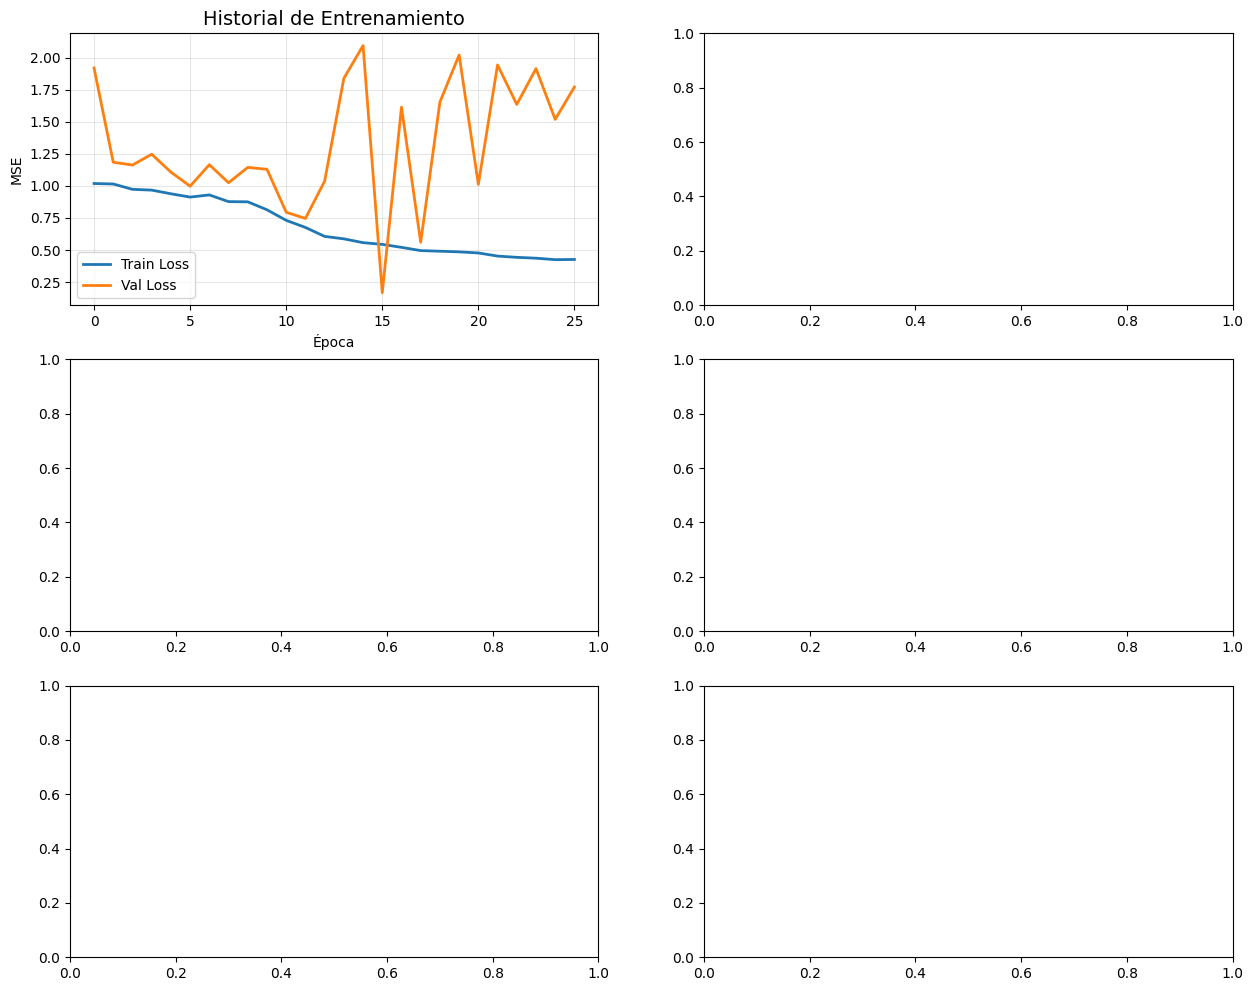

In [58]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# 7.1 Pérdidas de entrenamiento
axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0, 0].plot(val_losses, label='Val Loss', linewidth=2)
axes[0, 0].set_title('Historial de Entrenamiento', fontsize=14)
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 7.2 Serie completa - CORREGIDO
# Usar s_log_train, s_log_val, s_log_test que son las series en escala logarítmica
train_original = np.exp(s_log_train)  # Convertir a escala original
val_original = np.exp(s_log_val)
test_original = np.exp(s_log_test)

# Para las predicciones, necesitamos alinear los índices
# Los datos de test para predicción comienzan después de la ventana
test_start_idx = len(train_original) + len(val_original) + ventana
pred_original_aligned = pred_original  # Ya está en escala original

# Gráfica de la serie completa
axes[0, 1].plot(train_original, label='Train', alpha=0.7)
axes[0, 1].plot(range(len(train_original), len(train_original) + len(val_original)), 
                val_original, label='Val', alpha=0.7)
axes[0, 1].plot(range(test_start_idx, test_start_idx + len(pred_original_aligned)), 
                pred_original_aligned, label='Test Pred', linestyle='--', linewidth=2, color='red')
axes[0, 1].plot(range(len(train_original) + len(val_original), 
                     len(train_original) + len(val_original) + len(test_original)), 
                test_original, label='Test Real', linewidth=2)
axes[0, 1].set_title('Serie Completa con Predicciones', fontsize=14)
axes[0, 1].set_xlabel('Día')
axes[0, 1].set_ylabel('Precio')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 7.3 Zoom en test
n_zoom = min(100, len(test_original))
# Tomar las últimas n_zoom predicciones para alinearlas con el test
zoom_pred = pred_original_aligned[:n_zoom]
zoom_real = true_original[:n_zoom]

axes[1, 0].plot(zoom_real, label='Real', linewidth=2)
axes[1, 0].plot(zoom_pred, label='Predicho', linestyle='--', linewidth=2)
axes[1, 0].set_title(f'Zoom: Test (primeros {n_zoom} días)', fontsize=14)
axes[1, 0].set_xlabel('Día')
axes[1, 0].set_ylabel('Precio')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 7.4 Dispersión
r2_val = r2_score(true_original, pred_original_aligned)
axes[1, 1].scatter(true_original, pred_original_aligned, alpha=0.6, s=20)
min_val = min(true_original.min(), pred_original_aligned.min())
max_val = max(true_original.max(), pred_original_aligned.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal', linewidth=2)
axes[1, 1].set_title(f'Dispersión (R² = {r2_val:.4f})', fontsize=14)
axes[1, 1].set_xlabel('Real')
axes[1, 1].set_ylabel('Predicho')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 7.5 Error porcentual - CORREGIDO
error_pct = 100 * (pred_original_aligned - true_original) / true_original
axes[2, 0].hist(error_pct, bins=50, alpha=0.7, edgecolor='black')
axes[2, 0].axvline(0, color='r', linestyle='--', linewidth=2)
axes[2, 0].set_title('Distribución del Error Porcentual', fontsize=14)
axes[2, 0].set_xlabel('Error (%)')
axes[2, 0].set_ylabel('Frecuencia')
axes[2, 0].grid(True, alpha=0.3)

# 7.6 Predicción vs Tiempo (diferencia)
time_index = range(len(pred_original_aligned))
axes[2, 1].plot(time_index, pred_original_aligned - true_original, alpha=0.7)
axes[2, 1].axhline(0, color='r', linestyle='--', linewidth=1)
axes[2, 1].fill_between(time_index, 0, pred_original_aligned - true_original, 
                       where=(pred_original_aligned - true_original) >= 0, 
                       alpha=0.3, color='green', label='Sobreestimación')
axes[2, 1].fill_between(time_index, 0, pred_original_aligned - true_original,
                       where=(pred_original_aligned - true_original) < 0,
                       alpha=0.3, color='red', label='Subestimación')
axes[2, 1].set_title('Error a lo largo del Tiempo', fontsize=14)
axes[2, 1].set_xlabel('Día')
axes[2, 1].set_ylabel('Error (Predicho - Real)')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Estadísticas


ANÁLISIS ADICIONAL

Estadísticas de las diferencias (desnormalizadas):
  Media: 0.000231
  Desviación estándar: 0.010719
  Mínimo: -0.027306
  Máximo: 0.019911


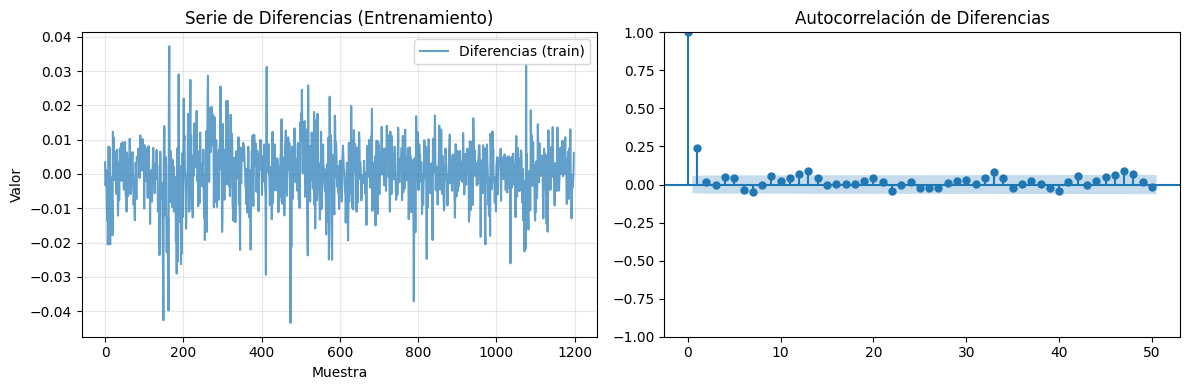

In [ ]:
print("\n" + "="*60)
print("ANÁLISIS DE PREDICCIÓN DE DIRECCIÓN")
print("="*60)

# Calcular dirección correcta
def calcular_direccion(real, pred):
    real_dir = np.sign(np.diff(real))
    pred_dir = np.sign(np.diff(pred))
    correct = (real_dir == pred_dir).mean()
    return correct

accuracy_direccion = calcular_direccion(true_original, pred_original)
print(f"Precisión en predicción de dirección: {accuracy_direccion*100:.1f}%")

# Predicción de n días adelante
print("\nPredicciones para los próximos 5 días:")
for i in range(min(5, len(pred_original))):
    print(f"  Día {i+1}: ${pred_original[i]:.2f} (Real: ${true_original[i]:.2f})")

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(s_diff_train)
print(f'ADF p-value: {result[1]}')

ADF p-value: 2.3478065870115463e-25
